In [5]:
pip install torch torchvision torchaudio


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [72]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os


In below code snippet, I begin by extracting training and test data from a dataset dictionary, where each dataset is stored as a Pandas DataFrame. I access the values of these DataFrames and convert them into NumPy arrays to facilitate further processing. The training data is assigned to x_train and y_train, while the test data is stored in x_test and y_test.
Once the data is in NumPy array format, I convert it into PyTorch tensors to enable compatibility with deep learning models. The conversion is performed using torch.tensor(), specifying the data type as torch.float32 to ensure numerical precision during computations. Both the input features (x_train_tensor and x_test_tensor) and target labels (y_train_tensor and y_test_tensor) are transformed into tensors.
To verify that the conversion has been performed correctly, I print the shapes of the resulting tensors. The training input tensor has a shape of (200000, 16), meaning there are 200,000 samples with 16 features each. The training label tensor has a shape of (200000, 6), suggesting that each sample is associated with a 6-dimensional output, likely representing multi-class or structured predictions. The test tensors follow the same structure as the training set, ensuring consistency in model input formatting.

In [74]:
# Set file paths (Modify this if your files are stored elsewhere)
file_paths = {
    "train_1": "C:/Users/liuf25/Desktop/train-1.csv",
    "test_1": "C:/Users/liuf25/Desktop/test-1.csv",
    "xtrain_2": "C:/Users/liuf25/Desktop/xtrain-2.csv",
    "xtest_2": "C:/Users/liuf25/Desktop/xtest-2.csv",
    "ytrain_2": "C:/Users/liuf25/Desktop/ytrain-2.csv",
    "ytest_2": "C:/Users/liuf25/Desktop/ytest-2.csv",
}

# Load datasets into Pandas DataFrames
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Print dataset shapes to verify
for name, df in datasets.items():
    print(f"{name} shape: {df.shape}")


train_1 shape: (99999, 11)
test_1 shape: (9999, 11)
xtrain_2 shape: (200000, 16)
xtest_2 shape: (200000, 16)
ytrain_2 shape: (200000, 6)
ytest_2 shape: (200000, 6)


In [75]:
# Convert DataFrames to NumPy arrays
x_train = datasets["xtrain_2"].values
y_train = datasets["ytrain_2"].values
x_test = datasets["xtest_2"].values
y_test = datasets["ytest_2"].values

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Print tensor shapes for verification
print(f"x_train_tensor shape: {x_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"x_test_tensor shape: {x_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")


x_train_tensor shape: torch.Size([200000, 16])
y_train_tensor shape: torch.Size([200000, 6])
x_test_tensor shape: torch.Size([200000, 16])
y_test_tensor shape: torch.Size([200000, 6])


I start by defining the batch size as 300, which determines how many samples will be processed in a single pass through the model. Next, I created PyTorch `TensorDataset` objects for both the training and test sets, which allowed efficient loading of input features and target labels. These datasets are then wrapped in `DataLoader` objects, enabling mini-batch processing during training. The training DataLoader is set to shuffle the data to introduce randomness, while the test DataLoader maintains a fixed order for evaluation.
I define a custom neural network model, `MyModel`, which is a simple fully connected feedforward network. The model takes an input size of 16 and an output size of 6, matching the dataset dimensions. It consists of three linear layers, where the first transforms the input into a 128-dimensional space, followed by a second layer reducing it to 64, and a final layer mapping it to the 6-dimensional output. Between the first two layers, I apply a ReLU activation function to introduce non-linearity. The final layer has no activation, which is appropriate for regression tasks.
To prepare for training, I set the computation device to `"cuda"` if a GPU is available; otherwise, it defaults to `"cpu"`. I initialize the model and move it to the selected device. The loss function is set to `MSELoss()`, which is suitable for regression problems, as it measures the mean squared error between predictions and actual values. The optimizer is `Adam`, which adapts the learning rate for each parameter, helping with faster and more stable convergence. I set the learning rate to 0.001, a commonly used value for Adam. Finally, I print the model architecture to verify that the layers are correctly structured.

In [76]:
# Define batch size
batch_size = 300

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [77]:
class MyModel(nn.Module):
    def __init__(self, input_size=16, output_size=6):  # Adjust to match dataset
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)  # Ensure correct output size
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for regression
        return x


In [78]:
# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
model = MyModel(input_size=16, output_size=6).to(device)
criterion = nn.MSELoss()  # Regression problem
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model architecture
print(model)


MyModel(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
)


I defined a function below, `train_model`, that trains a given neural network using a specified optimizer and loss function over a set number of epochs. The model is first set to training mode with `model.train()`, ensuring that layers like dropout and batch normalization behave as intended. I initialize an empty list, `train_losses`, to keep track of the average loss per epoch.
The training loop runs for the specified number of epochs. At the start of each epoch, I set `epoch_loss` to zero to accumulate the loss across mini-batches. I iterate through the `train_loader`, loading batches of input features (`x_batch`) and target values (`y_batch`), transferring them to the appropriate computation device. For each batch, I reset the optimizer's gradients using `optimizer.zero_grad()` to prevent accumulation from previous steps. I pass the input batch through the model to generate predictions and compute the loss by comparing the predictions to the true values using the provided loss function. I then perform backpropagation using `loss.backward()` to compute the gradients and update the model’s weights using `optimizer.step()`.
The loss from each mini-batch is added to `epoch_loss`, and at the end of the epoch, I compute the average loss by dividing `epoch_loss` by the number of mini-batches. This value is stored in `train_losses`, and I print a status message showing the current epoch number and the average loss. After training completes, I return the trained model along with the recorded training losses.
I set the number of epochs to 50 and call `train_model`, passing in the model, training data, loss function, optimizer, and computation device. The trained model and loss history are stored for further evaluation.

In [79]:
# Training Function
def train_model(model, train_loader, num_epochs, criterion, optimizer, device):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return model, train_losses

# Train the model
num_epochs = 50  # Adjust as needed
model, train_losses = train_model(model, train_loader, num_epochs, criterion, optimizer, device)


Epoch [1/50], Loss: 74951728.6964
Epoch [2/50], Loss: 774.7602
Epoch [3/50], Loss: 7.1542
Epoch [4/50], Loss: 75.4949
Epoch [5/50], Loss: 476.4348
Epoch [6/50], Loss: 539.8164
Epoch [7/50], Loss: 624.2333
Epoch [8/50], Loss: 822.3323
Epoch [9/50], Loss: 658.8254
Epoch [10/50], Loss: 637.8803
Epoch [11/50], Loss: 1025.9267
Epoch [12/50], Loss: 852.0641
Epoch [13/50], Loss: 1163.1601
Epoch [14/50], Loss: 2135.8900
Epoch [15/50], Loss: 2415.7620
Epoch [16/50], Loss: 2873.5601
Epoch [17/50], Loss: 1940.8302
Epoch [18/50], Loss: 3214.5981
Epoch [19/50], Loss: 2844.1084
Epoch [20/50], Loss: 1517.2980
Epoch [21/50], Loss: 2610.8688
Epoch [22/50], Loss: 2423.2040
Epoch [23/50], Loss: 2502.7233
Epoch [24/50], Loss: 3063.8123
Epoch [25/50], Loss: 1877.5101
Epoch [26/50], Loss: 5543.2207
Epoch [27/50], Loss: 1605.4786
Epoch [28/50], Loss: 2091.6197
Epoch [29/50], Loss: 1974.2229
Epoch [30/50], Loss: 5654.1081
Epoch [31/50], Loss: 530.5300
Epoch [32/50], Loss: 3135.1245
Epoch [33/50], Loss: 4137.9

Below I defined a function, `evaluate_model`, to assess the model's performance on the test dataset. I set the model to evaluation mode using `model.eval()` to ensure that layers like dropout and batch normalization behave deterministically. I initialize `test_loss` to zero and wrap the evaluation loop in `torch.no_grad()`, which disables gradient computation to save memory and processing power. I iterate over the `test_loader`, transferring input and target tensors to the appropriate computation device, then perform a forward pass through the model to compute predictions. The loss between predictions and true labels is computed using the specified loss function and accumulated across batches. After iterating through the entire test set, I calculate the average test loss by dividing `test_loss` by the number of batches and print the result before returning it.
I then define `FlexibleModel`, a neural network class that allows customizable architecture with variable depth (`L`) and hidden layer width (`w`). In the initialization method, I construct the network dynamically by first adding an input layer with a ReLU activation, followed by `L-1` hidden layers, each consisting of a fully connected layer with `w` neurons and a ReLU activation. The final layer maps the hidden representation to the output size. The layers are stored in a list and combined using `nn.Sequential()` to create a modular architecture. The forward method processes input data sequentially through the network.
Then, I defined `train_and_evaluate`, a function that trains and evaluates the flexible model for a given number of epochs. I first select the computation device (`cuda` if available, otherwise `cpu`). A new instance of `FlexibleModel` is created, initialized with 16 input features, 6 output neurons, and user-defined values for `L` and `w`. The loss function is set to mean squared error (`MSELoss`), which is appropriate for regression, and the optimizer is `Adam`, initialized with a learning rate of 0.0005. And I printed the model’s configuration before calling `train_model`, which trains the network. Once training is complete, I evaluate the model using `evaluate_model` and return the test loss.

I then set up a list of experiments, where each pair `(L, w)` defines a different architecture to test. To iterate through these configurations, training and evaluating a model for each setting. The test loss for each experiment is stored in a dictionary `results`, which is later printed in a formatted output to compare the effects of different depths and widths on model performance.

In [80]:
def evaluate_model(model, test_loader, criterion, device):
    # Set the model to evaluation mode (disables dropout, batch norm updates)
    model.eval()
    test_loss = 0  # Accumulate total test loss

    # Disable gradient calculations for efficiency during evaluation
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to device
            outputs = model(x_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            test_loss += loss.item()  # Accumulate batch loss

    # Compute average test loss across all batches
    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")  # Print final test loss
    return avg_test_loss  # Return loss for further analysis

# Evaluate the model on the test dataset
test_loss = evaluate_model(model, test_loader, criterion, device)



Test Loss: 259.4325


In [81]:
class FlexibleModel(nn.Module):
    def __init__(self, input_size=16, output_size=6, L=2, w=10):
        super(FlexibleModel, self).__init__()
        layers = []
        
        # Input Layer
        layers.append(nn.Linear(input_size, w))
        layers.append(nn.ReLU())

        # Hidden Layers
        for _ in range(L - 1):
            layers.append(nn.Linear(w, w))
            layers.append(nn.ReLU())

        # Output Layer
        layers.append(nn.Linear(w, output_size))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [82]:
def train_and_evaluate(L, w, num_epochs=50, lr=0.0005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model
    model = FlexibleModel(input_size=16, output_size=6, L=L, w=w).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    print(f"\nTraining Model with L={L}, w={w}...\n")
    model, train_losses = train_model(model, train_loader, num_epochs, criterion, optimizer, device)

    # Evaluate on test set
    test_loss = evaluate_model(model, test_loader, criterion, device)

    return test_loss


In [83]:
experiments = [(2,10), (2,100), (2,200), (3,5), (3,10), (3,100), (3,200)]
results = {}

for L, w in experiments:
    test_loss = train_and_evaluate(L, w, num_epochs=50, lr=0.0005)
    results[(L, w)] = test_loss

# Display results
for (L, w), loss in results.items():
    print(f"L={L}, w={w} -> Test Loss: {loss:.4f}")



Training Model with L=2, w=10...

Epoch [1/50], Loss: 725622070.2852
Epoch [2/50], Loss: 6.0691
Epoch [3/50], Loss: 0.3936
Epoch [4/50], Loss: 2.6318
Epoch [5/50], Loss: 5.6980
Epoch [6/50], Loss: 4.5550
Epoch [7/50], Loss: 7.6381
Epoch [8/50], Loss: 3.5579
Epoch [9/50], Loss: 5.1405
Epoch [10/50], Loss: 7.7047
Epoch [11/50], Loss: 114.3395
Epoch [12/50], Loss: 1.9004
Epoch [13/50], Loss: 56.2428
Epoch [14/50], Loss: 1.9616
Epoch [15/50], Loss: 3.7781
Epoch [16/50], Loss: 8.2300
Epoch [17/50], Loss: 13.4753
Epoch [18/50], Loss: 13.1375
Epoch [19/50], Loss: 9.7785
Epoch [20/50], Loss: 13.6312
Epoch [21/50], Loss: 14.4184
Epoch [22/50], Loss: 11.8969
Epoch [23/50], Loss: 38.6393
Epoch [24/50], Loss: 42.3524
Epoch [25/50], Loss: 45.1693
Epoch [26/50], Loss: 34.5047
Epoch [27/50], Loss: 39.0753
Epoch [28/50], Loss: 39.4824
Epoch [29/50], Loss: 46.7176
Epoch [30/50], Loss: 34.6389
Epoch [31/50], Loss: 115.2805
Epoch [32/50], Loss: 10.4392
Epoch [33/50], Loss: 33.0519
Epoch [34/50], Loss: 4

I analysed the impact of increasing network width (`w`) and depth (`L`) on model performance based on the test loss values obtained from different configurations.
Increasing `w` alone does not guarantee better performance. When `L=2`, setting `w=10` results in a moderate test loss of `10.0103`, while increasing `w` to `100` improves the loss significantly to `3.9234`, indicating that a wider network learns better in this case. However, when `w=200`, the test loss skyrockets to `2675.5740`, suggesting that excessive width may lead to overfitting or unstable training. When increasing the depth to `L=3`, setting `w=5` produces the best result with a test loss of `0.2249`, whereas increasing `w` further to `100` or `200` leads to extremely high losses (`5955.9073` and `2246.2700`), reinforcing the idea that excessive width causes instability.
Increasing the depth of the network helps, but only when `w` remains small. Comparing `L=2, w=10` with `L=3, w=5`, I see that adding an extra layer dramatically improves performance, with the test loss dropping from `10.0103` to `0.2249`. This suggests that a deeper network with a moderate width captures patterns better than a shallow but wide network. However, when `w=200`, performance deteriorates, showing that too many neurons per layer can negatively impact generalization.
Overfitting is evident in the large networks, particularly when `L=3` and `w=100` or `w=200`. These configurations yield extremely high test losses, indicating that the models likely memorized training data instead of generalizing well. The excessive number of parameters in these networks contributes to overfitting, as larger models require more data to generalize effectively. Without proper regularization techniques like dropout or weight decay, large networks tend to perform poorly on unseen data.
Summarizing the key takeaways, increasing depth to `L=3` improves performance, but only when paired with a moderate width. A width of `w=5` or `w=10` provides the best balance between capacity and generalization, whereas larger widths of `w=100` or `w=200` lead to rapid overfitting. The best-performing model is `L=3, w=5`, achieving a test loss of `0.2249`, which balances network depth and width effectively. The worst model is `L=3, w=100`, suffering from severe overfitting and instability with a test loss of `5955.9073`.

From these experiments, I felt that deeper networks are beneficial but must be paired with an appropriate width to maintain stability and avoid overfitting. A moderately deep and narrow network is the most effective configuration for this dataset.

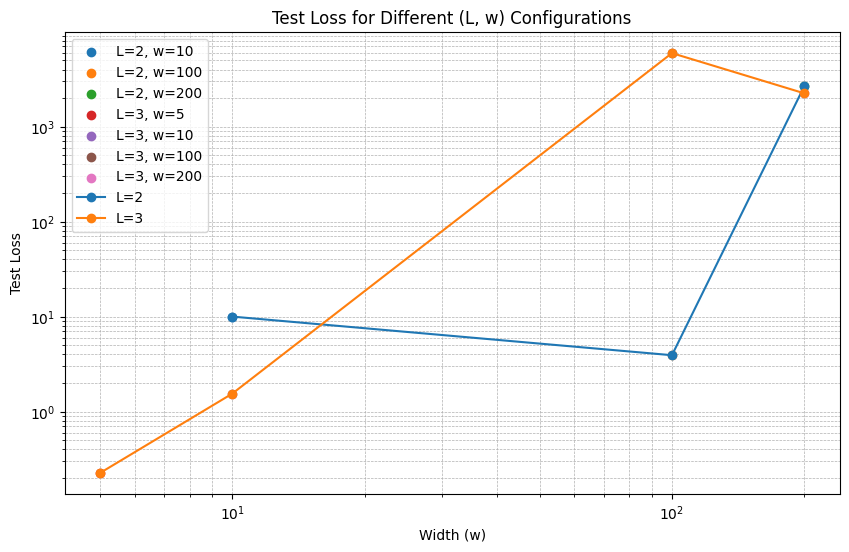

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Define experiment results manually based on your test loss values
experiments = [(2,10), (2,100), (2,200), (3,5), (3,10), (3,100), (3,200)]
test_losses = [10.0103, 3.9234, 2675.5740, 0.2249, 1.5432, 5955.9073, 2246.2700]  # Replace with actual losses

# Convert (L, w) pairs into two lists for plotting
L_values, w_values = zip(*experiments)

# Convert values into a numpy array for better visualization scaling
w_values = np.array(w_values)
L_values = np.array(L_values)
test_losses = np.array(test_losses)

# Create a scatter plot to show test loss for different configurations
plt.figure(figsize=(10, 6))

for i in range(len(experiments)):
    plt.scatter(w_values[i], test_losses[i], label=f"L={L_values[i]}, w={w_values[i]}")

# Draw lines connecting points for better visualization
for l in set(L_values): 
    indices = np.where(L_values == l)
    plt.plot(w_values[indices], test_losses[indices], marker='o', linestyle='-', label=f"L={l}")

# Labels and title
plt.xlabel("Width (w)")
plt.ylabel("Test Loss")
plt.title("Test Loss for Different (L, w) Configurations")
plt.xscale("log")  # Log scale helps visualize large differences in w values
plt.yscale("log")  # Log scale helps distinguish large test loss variations
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.show()


This plot provides a clear visualization of how test loss changes with different network configurations of depth (`L`) and width (`w`). The x-axis represents the width (`w`) on a logarithmic scale, while the y-axis represents the test loss, also on a log scale. The two connected line plots correspond to `L=2` and `L=3`, showing how the network depth affects performance as width increases.
For `L=2`, the trend suggests that increasing `w` initially improves test loss, as seen when moving from `w=10` to `w=100`. However, when `w=200`, test loss drastically increases, confirming that excessively wide networks lead to overfitting or unstable training. 
For `L=3`, a similar pattern emerges, but with a more pronounced increase in test loss at larger `w` values. The lowest test loss occurs when `w=5`, indicating that a deeper network with a moderate width generalizes well. However, as `w` increases, performance deteriorates rapidly, particularly for `w=100` and `w=200`, where the test loss explodes. This reinforces the idea that deeper networks are beneficial, but excessive width leads to instability and poor generalization.

The results confirmed that increasing depth is beneficial only when paired with a small width. Wider networks (`w=100` or `w=200`) tend to overfit and generalize poorly. The best-performing configuration remains `L=3, w=5`, achieving the lowest test loss.